In [273]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as func
import torch.utils.data
import torch.nn as nn
from time import time
import os
from matplotlib import pyplot as plt

### Загрузка данных

In [274]:
dir_name = os.getcwd()
batch_size = 256

In [275]:
train_img_transform = transforms.Compose([transforms.Resize((32,32)), transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_img_transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,0.5))])

In [277]:
train_dataset = datasets.CIFAR10(root=f'{dir_name}/data', train=True, download=True, transform=train_img_transform)
test_dataset = datasets.CIFAR10(root=f'{dir_name}/data', train=False, download=True, transform=val_img_transform)

100.0%


Extracting /home/polina/DLuny/deep-learning-course-practice-2023/3822М1ПМвм/practical_work_1/PlastovaPI/data/cifar-10-python.tar.gz to /home/polina/DLuny/deep-learning-course-practice-2023/3822М1ПМвм/practical_work_1/PlastovaPI/data
Files already downloaded and verified


In [278]:
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)

In [280]:
def tensor_to_img (tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

def show_images(loader):
    images, labels = next(iter(loader))
    classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 
        3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 
        8: 'ship', 9: 'truck'}
    fig = plt.figure()
    n_x = 3
    n_y = 3
    for img_id in np.arange(9):
        ax = fig.add_subplot(n_x, n_y, img_id + 1, xticks=[], yticks=[])
        ax.set_title(f"Class '{classes[labels[img_id].item()]}'")
        plt.imshow(tensor_to_img(images[img_id]))

Размеры выборок:

In [281]:
print("Number of train images: ", len(train_dataset))
print("Number of test images: ", len(test_dataset))

Number of train images:  50000
Number of test images:  10000


Примеры данных из тренировочной выборки:

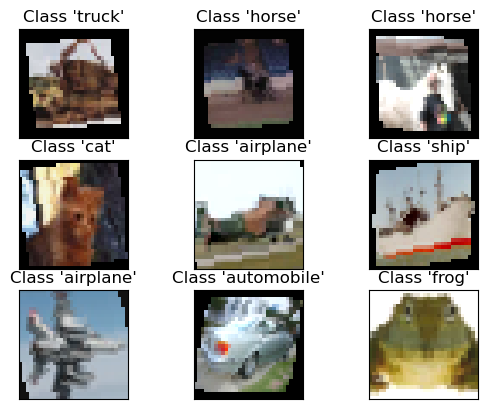

In [282]:
show_images(train_loader)

Примеры данных из тестовой выборки:

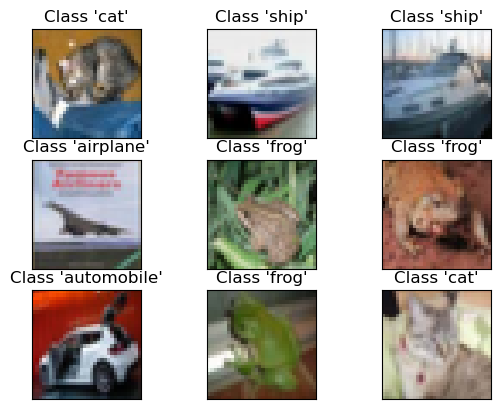

In [283]:
show_images(test_loader)

### Построение архитектуры сверточной сети

In [286]:
class my_cnn (nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.ful_con_1 = nn.Linear(in_features=128 * 3 * 3, out_features=200)
        self.ful_con_2 = nn.Linear(in_features=200, out_features=10)

    def forward(self, out):
        out = self.conv_1(out)
        out = func.relu(out)
        out = func.max_pool2d(out, kernel_size=2, stride=2)
        out = self.conv_2(out)
        out = func.relu(out)
        out = func.max_pool2d(out, kernel_size=2, stride=2)
        out = self.conv_3(out)
        out = func.relu(out)
        out = func.max_pool2d(out, kernel_size=2, stride=2)
        out = out.view(-1, 128*3*3)
        out = self.ful_con_1(out)
        out = func.relu(out)
        out = self.ful_con_2(out)
        return out

In [299]:
model = my_cnn()
model

my_cnn(
  (conv_1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ful_con_1): Linear(in_features=1152, out_features=200, bias=True)
  (ful_con_2): Linear(in_features=200, out_features=10, bias=True)
)

### Обучение модели

In [301]:
def get_accuracy(loader, model):
    tp = 0
    n = 0
    start_time = time()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    end_time = time()
    val_time = end_time - start_time
    accuracy = tp / n
    return accuracy, val_time

def train_model(model, num_epochs, learning_rate):
    if not torch.cuda.is_available():
        raise RuntimeError("Cuda device is not available")
    else: 
        device = torch.device("cuda:0")
        model.to(device)
        print(f'Device: {torch.cuda.get_device_name(device)}')

        total_time = 0
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        for epoch in range(num_epochs):
            epoch_start_time = time()
            for i, (images, labels) in enumerate(training_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            accuracy, _ = get_accuracy(training_loader, model)
            epoch_time = time() - epoch_start_time
            total_time += epoch_time
            print(f"Epoch #{epoch+1}: train accuracy = {'{:.3f}'.format(accuracy)}, error = {'{:.3f}'.format(1-accuracy)} time = {'{:.2f}'.format(epoch_time)} sec")
        print(f"Total training time: {total_time} sec")   

In [302]:
learning_rate = 0.001
num_epochs = 100

In [303]:
train_model(model, num_epochs, learning_rate)

Device: NVIDIA GeForce RTX 3060
Epoch #1: train accuracy = 0.512, error = 0.488 time = 29.94 sec
Epoch #2: train accuracy = 0.594, error = 0.406 time = 29.97 sec
Epoch #3: train accuracy = 0.641, error = 0.359 time = 29.95 sec
Epoch #4: train accuracy = 0.674, error = 0.326 time = 29.99 sec
Epoch #5: train accuracy = 0.688, error = 0.312 time = 30.14 sec
Epoch #6: train accuracy = 0.707, error = 0.293 time = 30.11 sec
Epoch #7: train accuracy = 0.720, error = 0.280 time = 30.06 sec
Epoch #8: train accuracy = 0.736, error = 0.264 time = 30.09 sec
Epoch #9: train accuracy = 0.744, error = 0.256 time = 30.06 sec
Epoch #10: train accuracy = 0.754, error = 0.246 time = 29.96 sec
Epoch #11: train accuracy = 0.762, error = 0.238 time = 30.01 sec
Epoch #12: train accuracy = 0.752, error = 0.248 time = 30.07 sec
Epoch #13: train accuracy = 0.769, error = 0.231 time = 30.00 sec
Epoch #14: train accuracy = 0.780, error = 0.220 time = 30.05 sec
Epoch #15: train accuracy = 0.788, error = 0.212 time

### Тестирование модели

In [310]:
accuracy, test_time = get_accuracy(test_loader, model)
print(f"Test accuracy: {'{:.3f}'.format(accuracy)}, error = {'{:.3f}'.format(1-accuracy)}, total test time = {'{:.2f}'.format(test_time)} sec, average_time = {'{:.10f}'.format(test_time/len(test_dataset))}")

Test accuracy: 0.821, error = 0.179, total test time = 0.99 sec, average_time = 0.0000992572
